In [1]:
%load_ext autoreload
%autoreload 2

from configs.RecursiveVPSDE.Markovian_3DLorenz.recursive_Markovian_PostMeanScore_3DLorenz_T256_H05_tl_5data import get_config

from configs import project_config
import numpy as np
import torch
import os

import matplotlib.pyplot as plt

In [2]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")
max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

Nepoch = 960

0.0
Using CPU



In [103]:
config.max_diff_steps = 10000
Ndiff = config.max_diff_steps
print(Ndiff)
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = ""
es = 0
file_path = (
        project_config.ROOT_DIR + f"experiments/results/TSPM_mkv_ES{es}_3DLorenz_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.max_diff_steps}DiffSteps").replace(
    ".", "")
muhats = torch.sum(torch.sum(torch.Tensor(np.load(file_path+"_muhats.npy", mmap_mode='r')[:, :, :4000,:]), dim=2), dim=2)
muhats1 = torch.sum(torch.sum(torch.Tensor(np.load(file_path+"_muhats.npy", mmap_mode='r')[:, :, 4000:8000,:]), dim=2), dim=2)
muhats3 = torch.sum(torch.sum(torch.Tensor(np.load(file_path+"_muhats.npy", mmap_mode='r')[:, :, 4000:8000,:]), dim=3), dim=2)
muhats = muhats+muhats1+muhats3
Xs = torch.Tensor(np.load(file_path+"_numpyXs.npy"))
if type == "":
    type="Standard"

10000


In [104]:
mu_muhats = muhats/(10000*50)#torch.sum(torch.sum(muhats, dim=3), dim=2)/(10000*50)
x = Xs[:, 0]
y = Xs[:, 1]
z = Xs[:, 2]
# Create a 3D mesh grid
true_mu0 = config.ts_sigma*(x-y)
true_mu1 = x*(config.ts_rho-z)-y
true_mu2 = x*y-config.ts_beta*z
del muhats

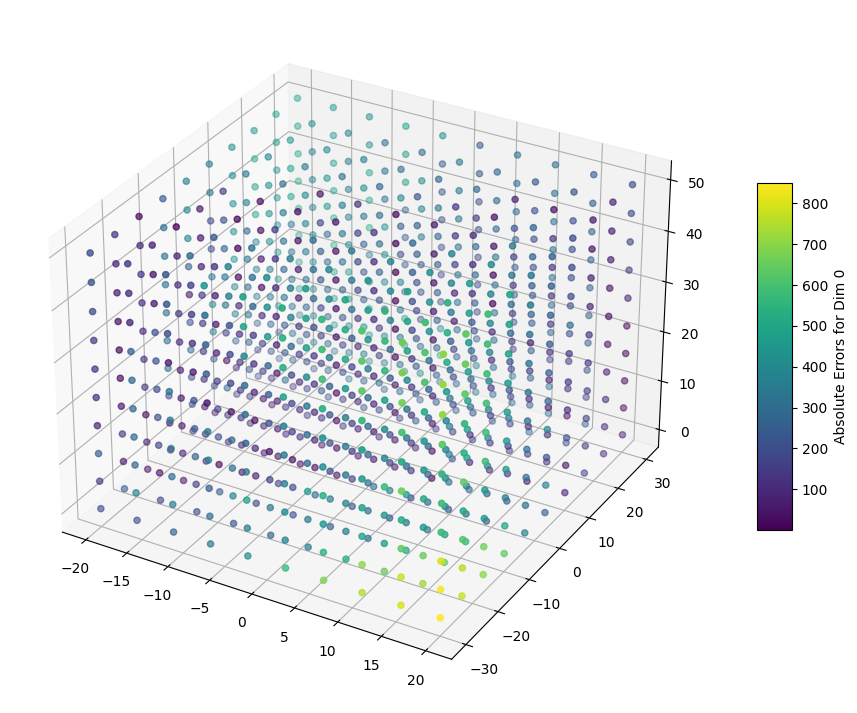

In [105]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')
# Normalize values for color mapping
values = torch.abs(true_mu0 - mu_muhats[:,0])
norm = Normalize(vmin=torch.min(values), vmax=torch.max(values))
colors = cm.viridis(norm(values))  # Choose a colormap, e.g., viridis

# Scatter plot with colors representing the function values
scatter = ax.scatter(x, y, z, c=values, cmap='viridis')
# Add a colorbar to show function values
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute Errors for Dim 0')

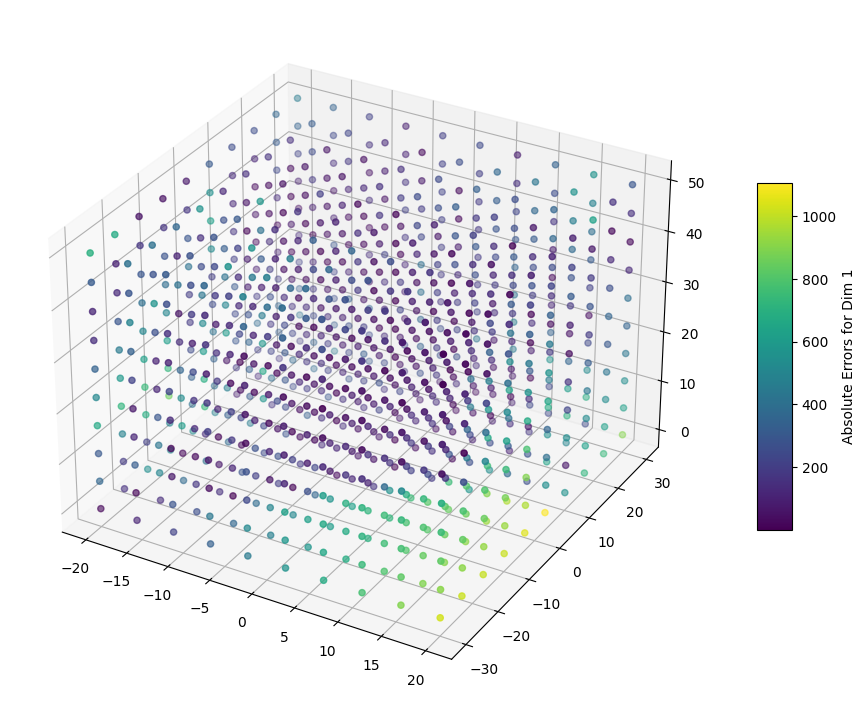

In [106]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')
# Normalize values for color mapping
values = torch.abs(true_mu1 - mu_muhats[:,1])
norm = Normalize(vmin=torch.min(values), vmax=torch.max(values))
colors = cm.viridis(norm(values))  # Choose a colormap, e.g., viridis

# Scatter plot with colors representing the function values
scatter = ax.scatter(x, y, z, c=values, cmap='viridis')
# Add a colorbar to show function values
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute Errors for Dim 1')

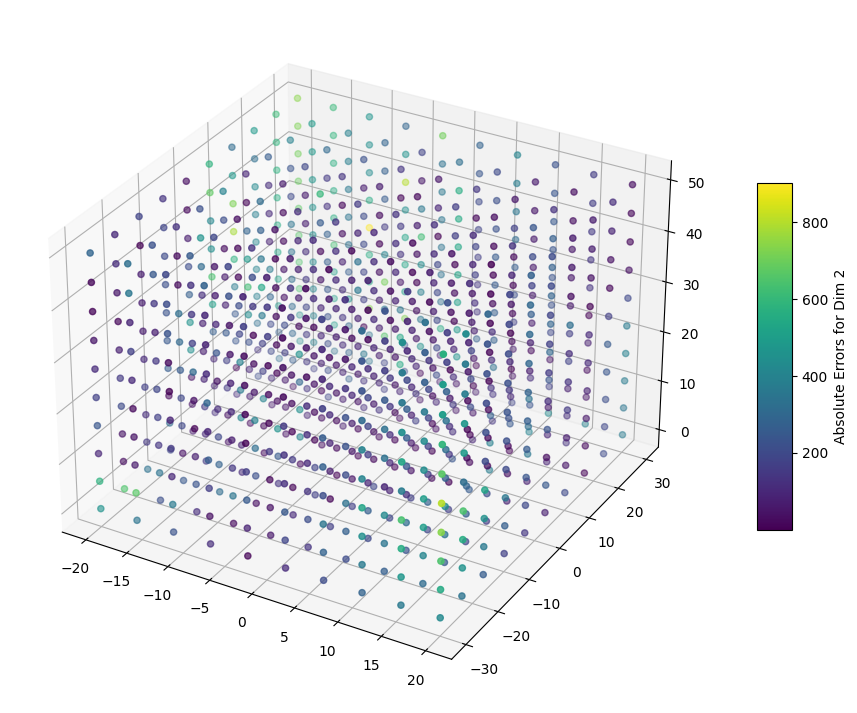

In [107]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')
# Normalize values for color mapping
values = torch.abs(true_mu2 - mu_muhats[:,2])
norm = Normalize(vmin=torch.min(values), vmax=torch.max(values))
colors = cm.viridis(norm(values))  # Choose a colormap, e.g., viridis

# Scatter plot with colors representing the function values
scatter = ax.scatter(x, y, z, c=values, cmap='viridis')
# Add a colorbar to show function values
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute Errors for Dim 2')

In [118]:
def plot_drift_estimator(mean, stds, numpy_Xs, type, toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = np.power(np.mean(np.power(np.sin(numpy_Xs) - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, np.sin(numpy_Xs), color="red", label="True Drift")

    ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Drift Estimator with 2 Std")
    ax.set_title(rf"RMSE {round(rmse,3)} of estimator $\bar{{\mu}}(x)$", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $x$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(loc="lower right", fontsize=25)
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fSin_{type}.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [119]:
print(type,muhats.shape)
assert (config.max_diff_steps == 1000)

Standard torch.Size([256, 10000, 50])


AssertionError: 

In [ ]:
true_drifts = np.sin(Xs).unsqueeze(-1)
diff_mses = (true_drifts - muhats.mean(dim=-1).numpy()).permute(1,0).pow(2).sum(dim=-1) / (muhats.shape[0])
diff_rmses = diff_mses.pow(0.5)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(np.linspace(config.sample_eps, config.end_diff_time, muhats.shape[1]), diff_rmses)
ax.set_title(r"Drift RMSE Against Diffusion Time $\tau_{s}$", fontsize=40)
ax.tick_params(labelsize=38)
plt.yscale("log")
ax.set_xlabel(r"Diffusion Time $\tau_{s}$", fontsize=48)
ax.set_ylabel(r"RMSE", fontsize=38)
plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fSin_{type}_RMSEs.png",  bbox_inches='tight')

In [ ]:
print(diff_rmses.min())

In [ ]:
mu_hats = muhats.mean(dim=-1).numpy()
per_diff_stds = muhats.std(dim=-1).numpy()

In [ ]:
for j in range(0, 50, -1):
    plot_drift_estimator(mean=mu_hats[:,j], stds=per_diff_stds[:, j], numpy_Xs=Xs.numpy(), type="type", toSave=False)

In [90]:
start_diff_idx = int(muhats.shape[1]*0.01)
end_diff_idx = int(muhats.shape[1]*1)
print(end_diff_idx)
mu_hats = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).mean(dim=-1).numpy()
stds = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).std(dim=-1).numpy()

10000


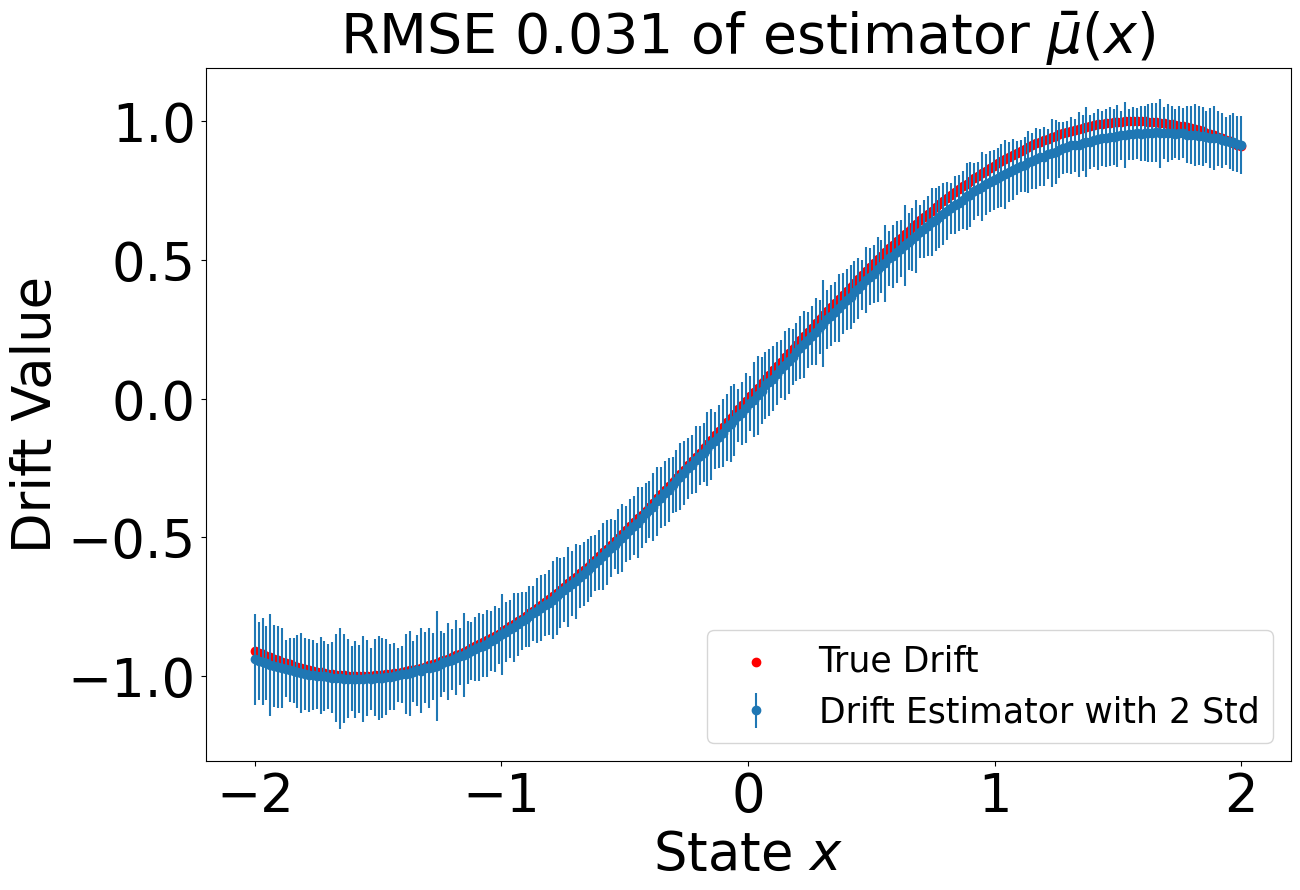

0.057921898


In [91]:
plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=Xs.numpy(), type=type, toSave=True)
print(np.mean(stds))